In [2]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.datasets import make_classification 
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import time
%matplotlib inline

In [3]:
# Loading data
attendance_model_df = pd.read_csv("./Resources/attendance_condensed_demographic_location_model_data.csv")
attendance_model_df.head()

,year,month,member,zipcode,adult,teen,child,small_family_group,medium_family_group,large_family_group,maingroup_Davis,maingroup_Salt Lake County,maingroup_Utah County
0,2022,2,0,84129,1,0,0,0,0,0,0,1,0
1,2022,2,0,84129,0,1,0,0,0,0,0,1,0
2,2022,2,0,84129,0,0,0,0,0,0,0,1,0
3,2022,2,1,84010,0,0,0,0,0,0,1,0,0
4,2022,2,1,84010,0,0,0,0,0,0,1,0,0


In [4]:
# Define features set
X = attendance_model_df.copy()
X.drop("member", axis=1, inplace=True)
X.head()

,year,month,zipcode,adult,teen,child,small_family_group,medium_family_group,large_family_group,maingroup_Davis,maingroup_Salt Lake County,maingroup_Utah County
0,2022,2,84129,1,0,0,0,0,0,0,1,0
1,2022,2,84129,0,1,0,0,0,0,0,1,0
2,2022,2,84129,0,0,0,0,0,0,0,1,0
3,2022,2,84010,0,0,0,0,0,0,1,0,0
4,2022,2,84010,0,0,0,0,0,0,1,0,0


In [5]:
# Define target vector
y = attendance_model_df["member"].ravel()
y[:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [225]:
# define dataset for model. Full dataset = 606729, with target variable ('member' = 1) = 235697. 20%-30% of this subset = 47,139 - 70709
x, y = make_classification(n_samples=50000) 
smote = SMOTE() 
x_smote, y_smote = smote.fit_resample(x, y) 
  
# print the features and the labels 
print('x_smote:\n', x_smote) 
print('y_smote:\n', y_smote) 

x_smote:
 [[ 1.05294356 -1.13538338 -0.45988525 ... -1.10842216 -0.48909746
   1.03235201]
 [-0.03740528 -1.53702565 -1.78720424 ...  1.09409981  2.07033238
   0.49617387]
 [-0.15968451 -0.39297893  0.30339965 ...  0.75905609 -0.93742198
  -1.1983684 ]
 ...
 [ 0.50291642  1.22675996  0.61729861 ... -0.13349331 -0.21567724
   0.33803427]
 [-0.3097584   1.79550836 -0.3699734  ...  0.83475935 -0.03771247
   0.69572115]
 [-0.19197235  2.09537081 -1.03929606 ... -0.71363776 -1.35488239
  -0.59602413]]
y_smote:
 [0 0 1 ... 1 1 1]


In [226]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, random_state=24)

In [227]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [228]:
# Fitting the Random Forest Model
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=6, max_depth=5, min_samples_split=4, min_samples_leaf=5, random_state=24)

In [229]:
# Fitting the model
start_time = time.time()

rf_model = rf_model.fit(X_train_scaled, y_train)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  0.702650785446167


In [230]:
# Making Predictions Using the testing data and the Random Forest Model
predictions = rf_model.predict(X_test_scaled)

In [231]:
# Get the feature importance array
importances = rf_model.feature_importances_

In [232]:
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.3447946379594577, 'month'),
 (0.3113607818706035, 'teen'),
 (0.06079071081472879, 'maingroup_Salt Lake County'),
 (0.000630935487595529, 'small_family_group'),
 (0.0005221828294699924, 'adult'),
 (0.00043033535338749755, 'zipcode'),
 (0.00026174190236037605, 'medium_family_group'),
 (0.00016979499682410318, 'maingroup_Utah County'),
 (8.261143602895834e-05, 'year'),
 (8.205416028021815e-05, 'maingroup_Davis')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

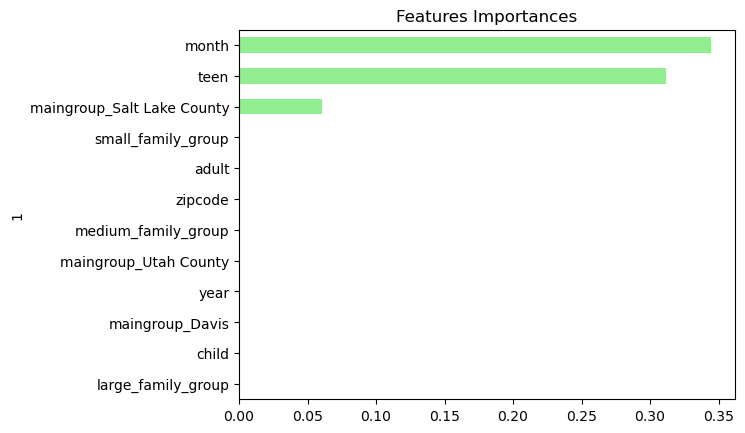

In [233]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [234]:
# Model Evaluation
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [235]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,5589,631
Actual 1,591,5703


Accuracy Score : 0.9023493687070481
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6220
           1       0.90      0.91      0.90      6294

    accuracy                           0.90     12514
   macro avg       0.90      0.90      0.90     12514
weighted avg       0.90      0.90      0.90     12514

